In [1]:
import numpy as np
import pandas as pd
import matplotlib
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
label_path = 'dataset/labels2.csv'
dataset_path = 'dataset/train/'
test_path = 'dataset/test/'

In [3]:
# load dataset
dataset_df = pd.read_csv(label_path)
dataset_df.shape

(10222, 4)

In [4]:
#Create a list of random numbers for a batch of training images
batch = np.random.permutation(np.arange(0,len(dataset_df)))[0:32]
# Visualise sample data
print(batch)
batch_df = dataset_df.loc[batch,:]
batch_df.head()

[9581 4472 9234 8587 3947 8175 3904  568  614 4187 1216 5916 3685 5174
 1136 4628 5010   72 5247 7122 9015 6751 5145 9101 8041 4874 4321 4161
 8450 3305 7546 4869]


,id,breed,image_path,label
9581,f065f6e63169c7d2ec46174000a2d87e,bloodhound,dataset/train/f065f6e63169c7d2ec46174000a2d87e...,63
4472,6f9f76d5b090ee0691154de6cbc70c2f,pomeranian,dataset/train/6f9f76d5b090ee0691154de6cbc70c2f...,66
9234,e7fda54b5e96c6048dad68414568f142,west_highland_white_terrier,dataset/train/e7fda54b5e96c6048dad68414568f142...,67
8587,d76a1cf6c6577f55114001bc8fa1d028,cardigan,dataset/train/d76a1cf6c6577f55114001bc8fa1d028...,107
3947,61f663ab9aa9c3cc41f207be4d4fd9e9,greater_swiss_mountain_dog,dataset/train/61f663ab9aa9c3cc41f207be4d4fd9e9...,5


In [5]:
p = dataset_path + batch_df.values[0][0] + '.jpg'
p

'dataset/train/f065f6e63169c7d2ec46174000a2d87e.jpg'

In [6]:
# fig, axs = plt.subplots(4, 8)
# fig.set_size_inches(12, 12)
# for i in range(4):
#     for j in range(8):
#         p = dataset_path + batch_df.values[(8*i)+j][0] + '.jpg'
#         image = mpimg.imread(p, (64,64))
#         axs[i, j].axis('off')
#         axs[i, j].imshow(image)

In [7]:
# add path of image to dataset_df for each image
dataset_df['image_path'] = dataset_df.apply(lambda dataset_df: (dataset_path + dataset_df["id"] + ".jpg" ), axis=1)
dataset_df.head()

,id,breed,image_path,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,dataset/train/000bec180eb18c7604dcecc8fe0dba07...,33
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,dataset/train/001513dfcb2ffafc82cccf4d8bbaba97...,47
2,001cdf01b096e06d78e9e5112d419397,pekinese,dataset/train/001cdf01b096e06d78e9e5112d419397...,41
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,dataset/train/00214f311d5d2247d5dfe4fe24b2303d...,90
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,dataset/train/0021f9ceb3235effd7fcde7f7538ed62...,116


In [8]:
dataset_df.to_csv('dataset/labels2.csv', index=False)

In [9]:
# create categorical data
dataset_df['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [10]:
labels = list(set(dataset_df['breed']))
print(len(labels))
mapping = {i : label for i, label in zip(range(len(labels)), labels)}
mapping
indexes = {label : i for i, label in zip(range(len(labels)), labels)}
indexes

120


{'wire-haired_fox_terrier': 0,
 'mexican_hairless': 1,
 'bull_mastiff': 2,
 'schipperke': 3,
 'komondor': 4,
 'ibizan_hound': 5,
 'dandie_dinmont': 6,
 'lakeland_terrier': 7,
 'airedale': 8,
 'staffordshire_bullterrier': 9,
 'bouvier_des_flandres': 10,
 'tibetan_mastiff': 11,
 'kuvasz': 12,
 'kelpie': 13,
 'chow': 14,
 'miniature_pinscher': 15,
 'pomeranian': 16,
 'tibetan_terrier': 17,
 'maltese_dog': 18,
 'west_highland_white_terrier': 19,
 'dhole': 20,
 'basenji': 21,
 'border_collie': 22,
 'collie': 23,
 'toy_poodle': 24,
 'redbone': 25,
 'english_setter': 26,
 'leonberg': 27,
 'english_foxhound': 28,
 'brabancon_griffon': 29,
 'afghan_hound': 30,
 'rhodesian_ridgeback': 31,
 'greater_swiss_mountain_dog': 32,
 'japanese_spaniel': 33,
 'irish_terrier': 34,
 'welsh_springer_spaniel': 35,
 'great_dane': 36,
 'otterhound': 37,
 'newfoundland': 38,
 'italian_greyhound': 39,
 'walker_hound': 40,
 'rottweiler': 41,
 'pembroke': 42,
 'bluetick': 43,
 'flat-coated_retriever': 44,
 'beagle':

In [11]:
dataset_df['label'] = dataset_df.apply(lambda dataset_df: (indexes[dataset_df["breed"]]), axis=1)
dataset_df.head()

,id,breed,image_path,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,dataset/train/000bec180eb18c7604dcecc8fe0dba07...,72
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,dataset/train/001513dfcb2ffafc82cccf4d8bbaba97...,87
2,001cdf01b096e06d78e9e5112d419397,pekinese,dataset/train/001cdf01b096e06d78e9e5112d419397...,117
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,dataset/train/00214f311d5d2247d5dfe4fe24b2303d...,43
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,dataset/train/0021f9ceb3235effd7fcde7f7538ed62...,99


In [12]:
#Split the training data to 2 parts- training data, validation data(0.1)
#Copy the data to 2 different files- training_data.csv, validation_data.csv containing image ids and 
from itertools import islice
def copy_data(inputPath, destPath, start, end):  
    # open data file in read mode 
    fn = open(inputPath, 'r') 
    
    # open other file in write mode 
    fn1 = open(destPath, 'w') 
    
    # read the content of the file line by line 
    cont = fn.readlines()
    for i in range(0, len(cont)): 
        if(i>=start and i<=end): 
            fn1.write(cont[i]) 
        else: 
            pass
    
  # close all files 
    fn.close() 
    fn1.close()

train_end = int(dataset_df.shape[0]*0.9)+1
val_end = int(train_end + dataset_df.shape[0]*0.1)

print('train_end: ', train_end)
print('val_end: ', val_end)
print('df size: ', dataset_df.shape[0])

# train_end = df.shape[0]*0.9
# val_end = train_end + df.shape[0]*0.1

# print('train_end: ', train_end)
# print('val_end: ', val_end)

train_end:  9200
val_end:  10222
df size:  10222


In [13]:
# copy data to files
training_images = 'dataset/train.csv'
validation_images = 'dataset/validation.csv'
# copy_data(label_path, training_images, 1, train_end)
# copy_data(label_path, validation_images, train_end+1, val_end)

## Model

In [15]:
from keras_preprocessing.image import ImageDataGenerator

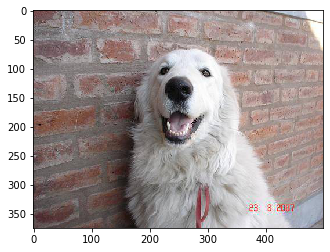

In [16]:
#Sample image for data augmentation
image_path = 'dataset/dog.jpg'
img=mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

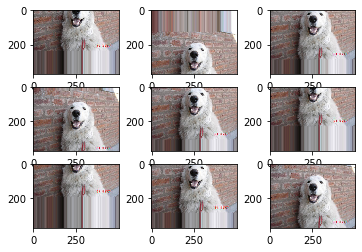

In [17]:
# example of vertical shift image augmentation
from numpy import expand_dims

from matplotlib import pyplot
# load the image
img = load_img('dataset/dog.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(height_shift_range=0.5)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')

val_datagen = ImageDataGenerator(rescale = 1./255)

train_df = pd.read_csv(training_images)
val_df = pd.read_csv(validation_images)

In [19]:
train_generator=train_datagen.flow_from_dataframe(dataframe=train_df, directory=None, x_col="image_path", y_col="breed", class_mode="categorical", target_size=(299,299), batch_size=32)
val_generator=val_datagen.flow_from_dataframe(dataframe=val_df, directory=None, x_col="image_path", y_col="breed", class_mode="categorical", target_size=(299,299), batch_size=32)

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


In [20]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(299, 299, 3))

In [21]:
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = 120
predictions = Dense(total_classes, activation='softmax')(out)

model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [22]:
callbacks = [ModelCheckpoint('model/best.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)]

In [23]:
batch_size = 32
history = model.fit_generator(train_generator, steps_per_epoch=train_end//batch_size, validation_data=val_generator, validation_steps= (val_end-train_end)// batch_size, epochs=100, callbacks=callbacks)


Epoch 1/100
287/287 [==============================] - 147s 513ms/step - loss: 3.5652 - accuracy: 0.3184 - val_loss: 1.5082 - val_accuracy: 0.7722

Epoch 00001: val_loss improved from inf to 1.50817, saving model to model/best.h5
Epoch 2/100
287/287 [==============================] - 147s 513ms/step - loss: 1.5368 - accuracy: 0.6470 - val_loss: 0.3701 - val_accuracy: 0.8646

Epoch 00002: val_loss improved from 1.50817 to 0.37008, saving model to model/best.h5
Epoch 3/100
287/287 [==============================] - 143s 498ms/step - loss: 1.1330 - accuracy: 0.6995 - val_loss: 0.3216 - val_accuracy: 0.8646

Epoch 00003: val_loss improved from 0.37008 to 0.32161, saving model to model/best.h5
Epoch 4/100
287/287 [==============================] - 145s 506ms/step - loss: 1.0146 - accuracy: 0.7192 - val_loss: 0.3707 - val_accuracy: 0.8828

Epoch 00004: val_loss did not improve from 0.32161
Epoch 5/100
287/287 [==============================] - 142s 494ms/step - loss: 0.9413 - accuracy: 0.731

287/287 [==============================] - 144s 500ms/step - loss: 0.4360 - accuracy: 0.8632 - val_loss: 0.3740 - val_accuracy: 0.8869

Epoch 00041: val_loss did not improve from 0.09303
Epoch 42/100
287/287 [==============================] - 147s 514ms/step - loss: 0.4308 - accuracy: 0.8646 - val_loss: 0.7014 - val_accuracy: 0.8939

Epoch 00042: val_loss did not improve from 0.09303
Epoch 43/100
287/287 [==============================] - 144s 501ms/step - loss: 0.4083 - accuracy: 0.8702 - val_loss: 0.3693 - val_accuracy: 0.9000

Epoch 00043: val_loss did not improve from 0.09303
Epoch 44/100
287/287 [==============================] - 142s 495ms/step - loss: 0.4208 - accuracy: 0.8677 - val_loss: 0.3295 - val_accuracy: 0.8677

Epoch 00044: val_loss did not improve from 0.09303
Epoch 45/100
287/287 [==============================] - 146s 509ms/step - loss: 0.4105 - accuracy: 0.8707 - val_loss: 0.5108 - val_accuracy: 0.8889

Epoch 00045: val_loss did not improve from 0.09303
Epoch 46/100


287/287 [==============================] - 145s 505ms/step - loss: 0.2825 - accuracy: 0.9096 - val_loss: 0.1287 - val_accuracy: 0.8909

Epoch 00082: val_loss did not improve from 0.04609
Epoch 83/100
287/287 [==============================] - 147s 511ms/step - loss: 0.2796 - accuracy: 0.9109 - val_loss: 0.3927 - val_accuracy: 0.8747

Epoch 00083: val_loss did not improve from 0.04609
Epoch 84/100
287/287 [==============================] - 146s 510ms/step - loss: 0.2658 - accuracy: 0.9146 - val_loss: 0.3509 - val_accuracy: 0.8869

Epoch 00084: val_loss did not improve from 0.04609
Epoch 85/100
287/287 [==============================] - 143s 497ms/step - loss: 0.2609 - accuracy: 0.9149 - val_loss: 1.2097 - val_accuracy: 0.8758

Epoch 00085: val_loss did not improve from 0.04609
Epoch 86/100
287/287 [==============================] - 145s 504ms/step - loss: 0.2669 - accuracy: 0.9143 - val_loss: 0.2038 - val_accuracy: 0.8919

Epoch 00086: val_loss did not improve from 0.04609
Epoch 87/100


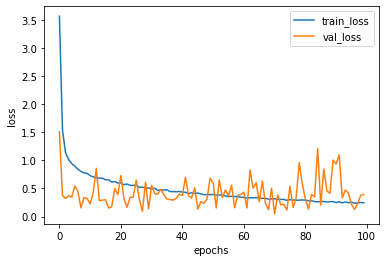

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [39]:
img_tmp = load_img('dataset/dog.jpg', target_size=(299,299))
img_tmp = img_to_array(img_tmp)
img_tmp = np.expand_dims(img_tmp, axis=0)
img_tmp = img_tmp / 255.0
print(np.shape(img_tmp))

(1, 299, 299, 3)


In [55]:
prediction = model.predict(img_tmp)

In [56]:
prediction = list(np.asfarray(prediction[0]))

In [58]:
prediction = [round(x, 18) for x in prediction]

In [60]:
np.shape(prediction)

(120,)

In [29]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

In [72]:
list(labels.values())

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [89]:
columns = ','.join(list(labels.values()))
columns

'affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,english_foxhound,english_setter,english_springer,entlebucher,eskimo_dog,flat-coated_retriever,french_bulldog,german_shepherd,german_short-haired_pointer,giant_schnauzer,golden_retriever,gordon_setter,great_dane,great_pyrenees,greater_swiss_mountain_dog,groenendael,ibizan_hound,irish_setter,irish_terrier,irish_water_spaniel,irish_wolfhound,italian_greyhound,japanese_spaniel,keeshond,kelpie,kerry_blue_terrier,komondor,kuvasz,labrador_retriever,lakeland_terrier,leonberg,lhasa,malamu

In [36]:
import glob
image_paths = glob.glob('dataset/test/*.jpg')
print(len(image_paths))

10357


In [37]:
image_paths[0]

'dataset/test/57df9fc7793c4c40e806167ea94773a5.jpg'

In [63]:
from keras.models  import load_model
best_model = load_model('model/best.h5')

In [64]:
def process_image(filename):
    img_tmp = load_img(filename, target_size=(299,299))
    img_tmp = img_to_array(img_tmp)
    img_tmp = np.expand_dims(img_tmp, axis=0)
    img_tmp = img_tmp / 255.0
    return img_tmp

In [66]:
from tqdm import tqdm

In [67]:
results = dict()

for image_path in tqdm(image_paths):
    image_key = (image_path.split('/')[-1]).split('.')[0]
    prediction = list(np.asfarray(best_model.predict(process_image(image_path))[0]))
    results[image_key] = prediction


100%|██████████| 10357/10357 [05:01<00:00, 34.31it/s]


In [75]:
for k, v in results.items():
    print('key: ', k, ' values: ', v)
    break

key:  57df9fc7793c4c40e806167ea94773a5  values:  [9.630787900505311e-08, 1.4211775090089418e-09, 3.63536645231477e-09, 4.389585228636861e-08, 2.0624668195523554e-06, 1.4372882883861848e-09, 2.2185749060099624e-07, 1.3065758475150346e-09, 3.962225214593218e-09, 2.4950520582933677e-06, 5.1434372316805366e-09, 3.818561467028303e-09, 9.91179582854329e-09, 1.1137054833909588e-08, 8.723528708287631e-07, 1.0500653679912375e-09, 4.974568534876767e-10, 3.1492155549983636e-09, 6.238106031730695e-09, 5.595930829827012e-09, 5.411457948412135e-08, 1.1683627398895169e-08, 1.5308881273767838e-08, 3.6201441844241344e-09, 5.879860509594437e-06, 4.4358678508160665e-08, 7.799663137575408e-09, 3.171184148609285e-10, 0.00010640582331689075, 2.11905444302829e-06, 4.702022593505717e-08, 9.906300135753554e-08, 4.815155421056261e-07, 7.748595862722141e-07, 0.00011891909525729716, 1.0372371406219827e-07, 1.1318788750713793e-07, 1.1514277531432526e-08, 1.714735117275268e-05, 2.3496697920677434e-08, 6.12269673183

In [84]:
final_result = []
for k, v in results.items():
    p = str(k)
    for i in v:
        p += ',{:.17f}'.format(i)
    final_result.append(p)
    p = ""

In [86]:
with open('prediction.txt', 'w') as f:
    for item in final_result:
        f.write("%s\n" % item)

In [85]:
final_result[0:5]

['57df9fc7793c4c40e806167ea94773a5,0.00000009630787901,0.00000000142117751,0.00000000363536645,0.00000004389585229,0.00000206246681955,0.00000000143728829,0.00000022185749060,0.00000000130657585,0.00000000396222521,0.00000249505205829,0.00000000514343723,0.00000000381856147,0.00000000991179583,0.00000001113705483,0.00000087235287083,0.00000000105006537,0.00000000049745685,0.00000000314921555,0.00000000623810603,0.00000000559593083,0.00000005411457948,0.00000001168362740,0.00000001530888127,0.00000000362014418,0.00000587986050959,0.00000004435867851,0.00000000779966314,0.00000000031711841,0.00010640582331689,0.00000211905444303,0.00000004702022594,0.00000009906300136,0.00000048151554211,0.00000077485958627,0.00011891909525730,0.00000010372371406,0.00000011318788751,0.00000001151427753,0.00001714735117275,0.00000002349669792,0.00000061226967318,0.00000000449084281,0.00000000063923711,0.00000000109015341,0.00000349995957549,0.00000000580009907,0.00000000404670519,0.00000478900801681,0.000

In [34]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

In [35]:
predict

[]

<img src='result/submission.png' />

In [ ]:
# The rank was around 650